# Peptide blocks and Fitting

In [9]:
import matplotlib.pyplot as plt
from pyhdx import PeptideMasterTable, read_dynamx, KineticsFitting
import os

In [2]:
data_dir = '../tests/test_data'
filename = 'ecSecB_apo.csv'
fpath = os.path.join(data_dir, filename)

We load the sample SecB dataset, apply the control, and split the dataset into ``KineticSeries``.

In [3]:
data = read_dynamx(fpath)
master_table = PeptideMasterTable(data, drop_first=1, ignore_prolines=True)
master_table.set_control(('Full deuteration control', 0.167))
states = master_table.groupby_state()
series = states['SecB WT apo']
series.make_uniform()

From this ``KineticsSeries`` object we can make a ``KineticsFitting`` object. The ``bounds`` parameter defines the upper
and lower limit of the kinetic rates which are fitted.

In [4]:
kf = KineticsFitting(series, bounds=(1e-2, 300))

(0.04818601436569138, 721.3475781522833)

We can now start the first step of fitting, by weighted averaging. The ``RuntimeWarning`` messages are normal and can be ignored.

In [5]:
result_wt_avg = kf.weighted_avg_fit()

<string>:2: RuntimeWarning: overflow encountered in exp
C:\Users\jhsmi\Miniconda3\envs\py36_hdx\lib\site-packages\symfit\core\objectives.py:321: RuntimeWarning: overflow encountered in square
  (dep_var_value - dep_data) ** 2 / sigma ** 2
C:\Users\jhsmi\Miniconda3\envs\py36_hdx\lib\site-packages\scipy\optimize\optimize.py:1985: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
<string>:2: RuntimeWarning: overflow encountered in exp
<string>:2: RuntimeWarning: overflow encountered in exp
<string>:2: RuntimeWarning: overflow encountered in exp
<string>:2: RuntimeWarning: overflow encountered in exp
<string>:2: RuntimeWarning: overflow encountered in exp
<string>:2: RuntimeWarning: overflow encountered in exp
<string>:2: RuntimeWarning: overflow encountered in exp
<string>:2: RuntimeWarning: overflow encountered in exp
<string>:2: RuntimeWarning: overflow encountered in exp
<string>:2: RuntimeWarning: overflow encountered in exp
<string>:2: RuntimeWa

The return value is a ``KineticsFitResult`` object. This object has a list of models, intervals in withing the protein 
sequence to which these models apply, and their corresponding ``symfit`` fit result with parameter values. The effective 
exchange rate can be extracted, as well as other fit parameters, from this object:

In [7]:
output = result_wt_avg.get_output(['rate', 'tau1', 'tau2', 'r'])
output.dtype.names

('r_number', 'rate', 'tau1', 'tau2', 'r')

Text(0, 0.5, 'Rate (min⁻¹)')

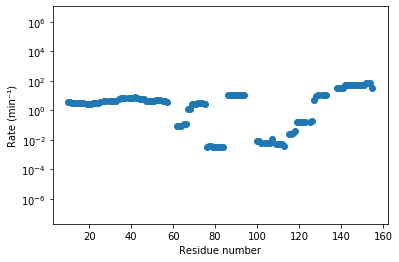

In [12]:
fig, ax = plt.subplots()
ax.set_yscale('log')
ax.scatter(output['r_number'], output['rate'])
ax.set_xlabel('Residue number')
ax.set_ylabel('Rate (min⁻¹)')

We can now use the weighted averaging fitted result as initial guesses for the global fitting step. This also returns a
``KineticsFitResult`` object but with different intervals, models and results.

In [13]:
result_global = kf.global_fit(output)

0.08739605726449762 10.624450399899168 0.5390408293856367
0.15741716815754803 94.3300789372067 0.6662807787263303
0.1251078997739299 14.529645257893016 0.6828811998543098
0.13612172908801146 69.14071952937164 0.74101979314706
0.07877468610456706 13.698400966510896 0.7083220143610058
0.0645199593645974 124.11271116125384 0.582381801364878
0.08048601454648108 184.50148268368898 0.6031129353852844
0.2227854245998091 99.94107683860643 0.46866561185738903
0.1146170058266307 99.97283574059566 0.5821630765636158
6.649553292719979e-13 362.0106592161609 0.13783422097876236
0.06738409824897662 4.179094898439537 0.8068150255199963
0.45408136082630124 213.7649337403786 0.16600601353843497
0.3238602433320691 239.60068162943355 0.13190491526753081
0.09529337886272993 48.731292071563445 0.4574148425746736
0.0760985430121896 64.44368928070202 0.7854708547799438
0.018634505954273628 72.90001356557988 0.9


Text(0, 0.5, 'Rate (min⁻¹)')

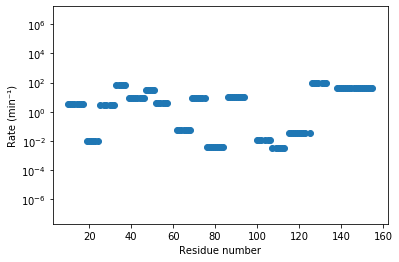

In [15]:
output_global = result_global.get_output(['rate', 'tau1', 'tau2', 'r'])
fig, ax = plt.subplots()
ax.set_yscale('log')
ax.scatter(output_global['r_number'], output_global['rate'])
ax.set_xlabel('Residue number')
ax.set_ylabel('Rate (min⁻¹)')

## High-performance fitting with Dask

Although fitting of a single medium sized protein will only take minutes on a typical computer, processing many datasets 
which cover many peptides can take long time. Therefore pyHDX supports parallel fitting through the parallel computing 
library ``Dask``. This allows fitting to be done in parallel or on a remote high-performance machine, thereby significantly
speeding up the fitting process. The prerequisite for parallel fitting is that the fitting problem can be split in 
independent tasks. Weighted averaging fitting can be split into many subtasks by default as each block of residues is
fitted separately. Parallelization of global fitting depends on the presence of regions of no coverage which split the
fitting problem into subproblems.

Parallel fitting in pyHDX uses the python 3.6+ ``async/await`` syntax together with an 
[asynchronous](https://distributed.dask.org/en/latest/asynchronous.html) ``dask`` client.  

In [16]:
from dask.distributed import LocalCluster, Client
import asyncio

First we need a ``dask`` cluster, either we connect to an existing cluster or we create a local cluster. 

In [20]:
cluster = LocalCluster(n_workers=8)
cluster.scheduler_address


C:\Users\jhsmi\Miniconda3\envs\py36_hdx\lib\site-packages\distributed\node.py:155: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 53916 instead
  http_address["port"], self.http_server.port


'tcp://127.0.0.1:53919'

By passing the cluster's scheduler address to a ``KineticsFitting`` object we can use it's ``async`` methods to do
asynchronous fitting. 

In [25]:
kf_async = KineticsFitting(series, cluster=cluster.scheduler_address, bounds=(1e-2, 300))

In jupyter notebooks, the ``async`` fitting methods can be directly ``await``ed

In [26]:
async_result_wt_avg = await kf_async.weighted_avg_fit_async()
async_output_wt_avg = async_result_wt_avg.get_output(['rate', 'tau', 'tau1', 'tau2', 'r'])

In [28]:
async_result_global = await kf_async.global_fit_async(async_output_wt_avg)


0.08749214424847152 10.590708398280555 0.5404435975613273
0.15950127160296868 96.25823129063477 0.666827876549952
0.13754938662474459 15.940432249816794 0.6982121656674496
0.1341949120721364 68.65282355372341 0.7405116836295967
0.07958552009506326 13.886172120194672 0.7095206792604312
0.0645199593645974 124.11271116125384 0.582381801364878
0.08048601454648108 184.50148268368898 0.6031129353852844
0.2200942415457905 99.93554305019961 0.47087017972302997
0.11390865145236706 99.9677802173087 0.58056055750549
6.649553292719979e-13 362.0106592161609 0.13783422097876236
0.06739198713149941 4.231733051222527 0.8072529705941432
0.45408136082630124 213.7649337403786 0.16600601353843497
0.3238602433320691 239.60068162943355 0.13190491526753081
0.09507698655070929 49.184011637089945 0.4573574046397223
0.0760985430121896 64.44368928070202 0.7854708547799438
0.01177101738050812 72.11165195772017 0.9


In [29]:
async_output_global = async_result_global.get_output(['rate', 'tau', 'tau1', 'tau2', 'r'])

We can verify that this produces the same result as the concurrent procedure.

Text(0, 0.5, 'Rate (min⁻¹)')

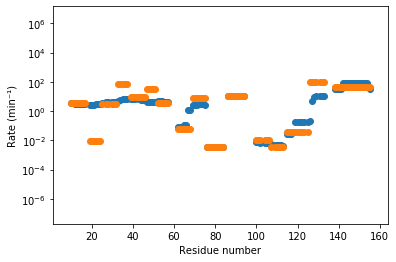

In [30]:
fig, ax = plt.subplots()
ax.set_yscale('log')
ax.scatter(async_output_wt_avg['r_number'], async_output_wt_avg['rate'])
ax.scatter(async_output_global['r_number'], async_output_global['rate'])
ax.set_xlabel('Residue number')
ax.set_ylabel('Rate (min⁻¹)')




